In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns

style.use("fivethirtyeight")
import gc
import math
import os
import sys

import h5py
import lightgbm as lgb
import pytorch_lightning as pl
import torch
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning import seed_everything
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from torch import nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm.auto import tqdm

pd.set_option("display.max_rows", 100)


SEED = 69
seed_everything(SEED)

69

# Prepare Dataset

In [2]:
%%time

# This code is needed for dataset
train = pd.read_pickle("riiid_train.pkl.gzip")
questions_df = pd.read_csv("questions.csv")
lectures_df = pd.read_csv("lectures.csv")

folder_path = "data"
print("Loading lectures arrays")
lectures_ids = np.load(f"{folder_path}/lectures_ids.npy")
lectures_parts = np.load(f"{folder_path}/lectures_parts.npy")
lectures_types = np.load(f"{folder_path}/lectures_types.npy")
lectures_tags = lectures_df.tag.values 

print("Loading questions arrays")
questions_parts = np.load(f"{folder_path}/questions_parts.npy")

# process tags
def split_tags(t):
    try:
        return [int(i) for i in t.split(" ")]
    except AttributeError:
        return list()

# Get tags to be 2D array of shape (Q, T), where Q is question_idx, and T is the max number of tag possible (6)
questions_df["tags"] = questions_df.tags.apply(split_tags)
questions_tags = pd.DataFrame(questions_df["tags"].tolist(), index=questions_df.index)
questions_tags = questions_tags.fillna(questions_tags.max().max()+1).astype(np.int).values # pad with max tag + 1

Loading lectures arrays
Loading questions arrays
CPU times: user 22 ms, sys: 1.06 s, total: 1.08 s
Wall time: 1.08 s


In [97]:
cv_train = pd.read_pickle(f"cv5_train.pickle")["row_id"]
cv_valid = pd.read_pickle(f"cv5_valid.pickle")["row_id"]

In [98]:
%%time
valid = train[train.row_id.isin(cv_valid)].copy()
train = train[train.row_id.isin(cv_train)].copy()
del cv_valid, cv_train
gc.collect()

CPU times: user 18.5 s, sys: 7 s, total: 25.5 s
Wall time: 25.5 s


23551

#### Part Features

In [3]:
questions_parts_mapping = dict(zip(np.arange(len(questions_parts)), questions_parts))
lectures_parts_mapping = dict(
    zip(lectures_df["lecture_id"].values, lectures_df["part"].values)
)

# Add part to lecture and questions
def add_part_to_df(df):
    df["part"] = 0
    df.loc[~df.content_type_id, "part"] = df[~df.content_type_id].content_id.map(
        questions_parts_mapping
    )
    df.loc[df.content_type_id, "part"] = df[df.content_type_id].content_id.map(
        lectures_parts_mapping
    )
    return df


def add_part_to_questions(df):
    df["part"] = df.content_id.map(questions_parts_mapping)
    return df

#### Time Features

In [4]:
def get_time_elapsed_from_timestamp(arr, max_minutes=300):
    # Saint+ way
    # Note this is isnt the smartest way..
    arr_seconds = np.diff(arr, prepend=1) // 1000
    arr_seconds[arr_seconds > max_minutes] = max_minutes
    return arr_seconds.astype(np.float32)

## Generate Hdf5

Only run this once.

In [112]:
train = add_part_to_df(train)

In [113]:
train.columns

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation',
       'part'],
      dtype='object')

In [ ]:
# ignore lectures for now
hf = h5py.File("feat_train.h5", "w")

for user_id, data in tqdm(train[~train.content_type_id].groupby("user_id")):
    processed_feats = data[
        [
            "content_id",
            "part",
            "answered_correctly",
            "timestamp",
        ]
    ].values

    hf.create_dataset(f"{user_id}/content_ids", data=processed_feats[:, 0], maxshape=(None,))
    hf.create_dataset(f"{user_id}/parts", data=processed_feats[:, 1], maxshape=(None,))
    hf.create_dataset(f"{user_id}/answered_correctly", data=processed_feats[:, 2], maxshape=(None,))
    hf.create_dataset(f"{user_id}/timestamps", data=processed_feats[:, 3], maxshape=(None,))

hf.close()

## Pytorch Stuff

### Data

Here we define the pytorch Dataset object and a custom collate function. 

In [5]:
WINDOW_SIZE = 200

In [6]:
class RIIDDataset(Dataset):
    """RIID dataset."""

    def __init__(
        self, user_mapping, hf5_file="feats_train.h5", window_size=WINDOW_SIZE,
    ):
        """
        Args:
            user_mapping (np.array): array of all unique user ids 
            hf5_file (string): location of hf5 feats file
        """
        # np array where index maps to a user id
        self.user_mapping = user_mapping
        self.hf5_file = hf5_file
        self.max_window_size = window_size

    def open_hdf5(self):
        # opens the h5py file
        self.f = h5py.File(self.hf5_file, "r")

    def __len__(self):
        return len(self.user_mapping)

    def __getitem__(self, idx):

        # open the hdf5 file in the iterator to allow multiple workers
        # https://github.com/pytorch/pytorch/issues/11929
        if not hasattr(self, "f"):
            self.open_hdf5()

        if torch.is_tensor(idx):
            idx = idx.tolist()

        user_id = self.user_mapping[idx]
        length = self.f[f"{user_id}/answered_correctly"].len()

        window_size = min(self.max_window_size, length)

        parts = np.zeros(window_size, dtype=np.int64).copy()
        content_ids = np.zeros(window_size, dtype=np.int64).copy()
        answered_correctly = np.zeros(window_size, dtype=np.int64).copy()
        timestamps = np.zeros(window_size, dtype=np.float32).copy()

        # index for loading larger than window size
        start_index = 0
        if length > window_size:
            # randomly select window size subset instead of trying to cram in everything
            start_index = np.random.randint(length - window_size)

        self.f[f"{user_id}/content_ids"].read_direct(
            content_ids,
            source_sel=np.s_[start_index : start_index + window_size],
            dest_sel=np.s_[0:window_size],
        )
        self.f[f"{user_id}/parts"].read_direct(
            parts,
            source_sel=np.s_[start_index : start_index + window_size],
            dest_sel=np.s_[0:window_size],
        )
        self.f[f"{user_id}/answered_correctly"].read_direct(
            answered_correctly,
            source_sel=np.s_[start_index : start_index + window_size],
            dest_sel=np.s_[0:window_size],
        )
        self.f[f"{user_id}/timestamps"].read_direct(
            timestamps,
            source_sel=np.s_[start_index : start_index + window_size],
            dest_sel=np.s_[0:window_size],
        )

        # convert timestamps to time elapsed
        time_elapsed_timestamps = get_time_elapsed_from_timestamp(timestamps)

        # get question tags
        tags = questions_tags[content_ids, :].astype(np.int64)

        # shift by one the answered_correctly sequence
        answers = np.roll(answered_correctly, 1)

        # set start token if start_index is actually first element
        if start_index == 0:
            answers[0] = 2
        # else replace first element of sequence with actual previous element
        else: 
            self.f[f"{user_id}/answered_correctly"].read_direct(
                answers,
                source_sel=np.s_[start_index-1],
                dest_sel=np.s_[0],
            )
        
        
        return {
            "parts": torch.from_numpy(parts),
            "tags": torch.from_numpy(tags),
            "content_ids": torch.from_numpy(content_ids),
            "answered_correctly": torch.from_numpy(answered_correctly),
            "answers": torch.from_numpy(answers),
            "timestamps": torch.from_numpy(time_elapsed_timestamps),
            "length": window_size,
        }

In [7]:
from torch.nn.utils.rnn import pad_sequence

# The collate function is used to merge individual data samples into a batch
# It handles the padding aspect
def collate_fn(batch):
    # collate lenghts into 1D tensor
    items = {"length": torch.tensor([batch_item["length"] for batch_item in batch])}

    # find shape that the batch will have
    max_length = items["length"].max()
    num_items = len(batch)

    # padding list
    for (key, padding) in [
        ("parts", 0),
        ("content_ids", 13523),
        ("answered_correctly", 3),
        ("answers", 3),
        ("timestamps", 0.0), # note timestamps isnt an embedding
        ("tags", 188),
    ]:
        items[key] = pad_sequence(
            [batch_item[key] for batch_item in batch],
            batch_first=False,
            padding_value=padding,
        )

    # mask to weight loss by (S, N)
    items["loss_mask"] = (
        (
            torch.arange(max_length).expand(num_items, max_length)
            < items["length"].unsqueeze(1)
        )
        .transpose(1, 0)
        .float()
    )

    items["answered_correctly"] = items["answered_correctly"].float()

    return items

In [8]:
# Create Dataset will all users
user_ids = train.user_id.unique()
dataset = RIIDDataset(user_ids,hf5_file="nn-data/feats.h5", window_size=WINDOW_SIZE)
len(dataset)

393656

### Model

In [9]:
from pytorch_lightning.core.decorators import auto_move_data
from pytorch_lightning.metrics.functional.classification import auroc
from torch.nn import TransformerEncoder, TransformerEncoderLayer


def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, sequence_length):
        # returns embeds (sequence_length, 1, d_model)
        return self.pe[:sequence_length, :]


class RIIDDTransformerModel(pl.LightningModule):
    def __init__(
        self,
        learning_rate=0.001,
        n_content_id=13524,  # number of different contents = 13523 + 1 (for padding)
        n_part=8,  # number of different parts = 7 + 1 (for padding)
        n_tags=189,  # number of different tags = 188 + 1 (for padding)
        emb_dim=64,  # embedding dimension
        dropout=0.1,
        n_heads: int = 1,
        n_encoder_layers: int = 2,
        n_decoder_layers: int = 2,
        dim_feedforward: int = 256,
        activation: str = "relu",
        batch_size=256,  # will get saved as hyperparam
        num_user_train=300000,  # will get saved as hyperparam
        num_user_val=30000,  # will get saved as hyperparam
        max_window_size=100,
        validate_on_sequence=True,
    ):
        super(RIIDDTransformerModel, self).__init__()
        self.model_type = "RiiidTransformer"
        self.learning_rate = learning_rate
        self.max_window_size = max_window_size
        self.validate_on_sequence = validate_on_sequence

        # save params of models to yml
        self.save_hyperparameters()

        self.embed_content_id = nn.Embedding(n_content_id, emb_dim, padding_idx=13523)
        self.embed_parts = nn.Embedding(n_part, emb_dim, padding_idx=0)
        self.embed_tags = nn.Embedding(n_tags, emb_dim, padding_idx=188)
        # exercise weights to weight the mean embeded excercise embeddings
        self.exercise_weights = torch.nn.Parameter(torch.tensor([0.35, 0.55, 0.1]))

        self.embed_answered_correctly = nn.Embedding(
            4, emb_dim, padding_idx=3
        )  # 2 + 1 for start token + 1 for padding_idn_inputs

        self.embed_timestamps = nn.Linear(1, emb_dim)

        self.pos_encoder = PositionalEncoding(emb_dim)

        self.transformer = nn.Transformer(
            d_model=emb_dim,
            nhead=n_heads,
            num_encoder_layers=n_encoder_layers,
            num_decoder_layers=n_decoder_layers,
            dropout=dropout,
            dim_feedforward=dim_feedforward,
            activation=activation,
        )

        self.out_linear = nn.Linear(emb_dim, 2)
        init_weights(self)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    @auto_move_data
    def forward(self, content_ids, parts, answers, tags, timestamps):
        # content_ids: (Source Sequence Length, Number of samples, Embedding)
        # tgt: (Target Sequence Length,Number of samples, Embedding)

        # if data is flat then expand to get Batch dim
        if len(content_ids.shape) == 1:
            content_ids = content_ids.unsqueeze(1)
            parts = parts.unsqueeze(1)
            answers = answers.unsqueeze(1)
            tags = tags.unsqueeze(1)
            timestamps = timestamps.unsqueeze(1)

        sequence_length = content_ids.shape[0]

        # sequence that will go into encoder
        embeded_content = self.embed_content_id(content_ids)
        embeded_parts = self.embed_parts(parts)
        embeded_tags = self.embed_tags(tags).sum(dim=2)
        e_w = F.softmax(self.exercise_weights, dim=0)

        embeded_exercise_sequence = (
            (embeded_content * e_w[0])
            + (embeded_parts * e_w[1])
            + (embeded_tags * e_w[2])
        )

        # sequence that will go into decoder
        embeded_responses = self.embed_answered_correctly(answers)
        embeded_timestamps = self.embed_timestamps(timestamps.unsqueeze(2))
        embeded_responses = (embeded_responses + embeded_timestamps) * 0.5

        # adding positional vector
        embedded_positions = self.pos_encoder(sequence_length)
        embeded_responses = embeded_responses + embedded_positions
        embeded_exercise_sequence = embeded_exercise_sequence + embedded_positions

        # mask of shape S x S -> prevents attention looking forward
        top_right_attention_mask = self.generate_square_subsequent_mask(
            sequence_length
        ).type_as(embeded_exercise_sequence)

        output = self.transformer(
            embeded_exercise_sequence,
            embeded_responses,
            tgt_mask=top_right_attention_mask,  # (S,S)
            src_mask=top_right_attention_mask,  # (T,T)
        )

        output = self.out_linear(output)
        return F.softmax(output, dim=2)[:, :, 1]

    def process_batch_step(self, batch):
        # return result
        return self(
            batch["content_ids"],
            batch["parts"],
            batch["answers"],
            batch["tags"],
            batch["timestamps"],
        )

    @auto_move_data
    def predict_n_steps(self, batch, steps, return_all_preds=False):
        """
        Predicts n steps for all items in batch and return predictions
        only for those steps (flattened)
        steps: tensor of length B where each item is the number of steps that need to be taken
        """
        n_users = batch["content_ids"].shape[1]
        lengths = batch["length"]

        users = torch.arange(n_users)

        user_indexes = []
        sequence_indexes = []

        for i in range(steps.max().int(), 0, -1):
            preds = model.process_batch_step(batch)

            sequence_indexes_at_i = lengths[steps >= i] - i
            user_indexes_at_i = users[steps >= i]

            # could do sampling here instead of greedy
            batch["answers"][sequence_indexes_at_i, user_indexes_at_i] = (
                preds[sequence_indexes_at_i, user_indexes_at_i] > 0.5
            ).long()

            user_indexes.append(user_indexes_at_i)
            sequence_indexes.append(sequence_indexes_at_i)

        if return_all_preds:
            return preds

        user_indexes = torch.cat(user_indexes)
        sequence_indexes = torch.cat(sequence_indexes)

        return (
            preds[sequence_indexes, user_indexes],
            batch["row_ids"][sequence_indexes, user_indexes],
        )

    @auto_move_data
    def predict_fast_single_user(
        self, content_ids, parts, answers, tags, timestamps, n=1
    ):
        """
        Predicts n steps for a single user in batch and return predictions
        only for those steps (flattened)
        """
        length = len(content_ids)
        out_predictions = torch.zeros(n, device=self.device)
        for i in range(n, 0, -1):
            preds = self(content_ids, parts, answers, tags, timestamps)
            out_predictions[n - i] = preds[length - i, 0]
            answers[length - i] = (preds[length - i, 0] > 0.5).long()
        return out_predictions

    def training_step(self, batch, batch_nb):
        result = self.process_batch_step(batch)
        loss = F.binary_cross_entropy(
            result, batch["answered_correctly"], weight=batch["loss_mask"]
        )
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_nb, dataset_nb=None):
        # find a random number of steps to predict for
        # number between 1 and 10 (randomly) - can never be x if min seq length is < x
        random_step = torch.randint(
            1, min(11, batch["length"].min() + 1), batch["length"].shape
        )
        result = self.predict_n_steps(batch, random_step, return_all_preds=True)
        loss = F.binary_cross_entropy(
            result, batch["answered_correctly"], weight=batch["loss_mask"]
        )
        self.log("val_loss_step", loss)
        select_mask = batch["loss_mask"] > 0
        positions = torch.cat(
            result.shape[1] * [torch.arange(result.shape[0]).unsqueeze(1)], dim=1
        )
        return (
            torch.masked_select(result, batch["loss_mask"] > 0),
            torch.masked_select(batch["answered_correctly"], batch["loss_mask"] > 0),
            torch.masked_select(positions, select_mask),
        )

    def validation_epoch_end(self, outputs):
        y_pred = torch.cat([out[0] for out in outputs], dim=0)
        y = torch.cat([out[1] for out in outputs], dim=0)
        pos = torch.cat([out[2] for out in outputs], dim=0)
        auc = auroc(y_pred, y)
        self.log("avg_val_auc", auc, prog_bar=True)

        # Calculate accuracy per position
        M = torch.zeros(pos.max() + 1, len(y), device=self.device)
        M[pos, torch.arange(len(y))] = 1
        M = torch.nn.functional.normalize(M, p=1, dim=1)
        acc_per_position = torch.mm(
            M, ((y_pred > 0.5) == y).float().unsqueeze(1)
        ).flatten()
        fig, ax = plt.subplots(figsize=(12, 8))
        sns.regplot(
            y=acc_per_position.cpu(), x=torch.arange(len(acc_per_position)).cpu(), ax=ax
        )
        ax.set_ylim(0.5, 1)
        ax.set_xlim(0, len(acc_per_position) - 1)
        ax.set_ylabel("acc")
        ax.set_xlabel("position")
        self.logger.experiment.add_figure(
            "val_acc_per_pos", fig, global_step=self.current_epoch
        )

    def test_step(self, batch, batch_nb, dataset_nb=None):
        # find a random number of steps to predict for
        # number between 1 and 11 (randomly) - can never be x if min seq length is < x
        random_step = torch.randint(
            1, min(11, batch["length"].min() + 1), batch["length"].shape
        )
        result = self.predict_n_steps(batch, random_step, return_all_preds=True)

        loss = F.binary_cross_entropy(
            result, batch["answered_correctly"], weight=batch["loss_mask"]
        )
        self.log("test_loss_step", loss)
        select_mask = batch["loss_mask"] > 0

        # positions indexes (S, B)
        positions = torch.cat(
            result.shape[1] * [torch.arange(result.shape[0]).unsqueeze(1)], dim=1
        )
        return (
            torch.masked_select(result, select_mask),
            torch.masked_select(batch["answered_correctly"], select_mask),
            torch.masked_select(positions, select_mask),
        )

    def test_epoch_end(self, outputs):
        y_pred = torch.cat([out[0] for out in outputs], dim=0)
        y = torch.cat([out[1] for out in outputs], dim=0)
        pos = torch.cat([out[2] for out in outputs], dim=0)
        auc = auroc(y_pred, y)
        self.log("avg_test_auc", auc, prog_bar=True)

        # Calculate accuracy per position
        M = torch.zeros(pos.max() + 1, len(y), device=self.device)
        M[pos, torch.arange(len(y))] = 1
        M = torch.nn.functional.normalize(M, p=1, dim=1)
        acc_per_position = torch.mm(
            M, ((y_pred > 0.5) == y).float().unsqueeze(1)
        ).flatten()
        fig, ax = plt.subplots(figsize=(12, 8))
        sns.regplot(
            y=acc_per_position.cpu(), x=torch.arange(len(acc_per_position)).cpu(), ax=ax
        )
        ax.set_ylim(0.5, 1)
        ax.set_xlim(0, len(acc_per_position) - 1)
        ax.set_ylabel("acc")
        ax.set_xlabel("position")
        self.logger.experiment.add_figure("test_acc_per_pos", fig, global_step=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="max", patience=10
            ),
            "monitor": "avg_val_auc",
            "interval": "epoch",
            "frequency": 1,
            "strict": True,
        }

        return [optimizer], [scheduler]

In [ ]:
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import random_split

seed_everything(SEED)


# Params
learning_rate = 0.001  # 0.0001
emb_dim = 64  # 256
dropout = 0.0
n_heads = 2  # 2
n_encoder_layers = 2
n_decoder_layers = 2
dim_feedforward = 256
batch_size = 256
num_user_train = 300000
num_user_val = 30000
max_window_size = WINDOW_SIZE


# create split
train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [num_user_train, num_user_val, len(dataset) - num_user_train - num_user_val,],
)

# Init DataLoader from RIIID Dataset subset
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=6,
    pin_memory=torch.cuda.is_available(),  # if GPU then pin memory for perf
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=512,
    collate_fn=collate_fn,
    num_workers=6,
    pin_memory=torch.cuda.is_available(),
)


# Init our model
model = RIIDDTransformerModel(
    learning_rate=learning_rate,
    emb_dim=emb_dim,  # embedding dimension - this is for everything
    dropout=dropout,
    n_heads=n_heads,
    n_encoder_layers=n_encoder_layers,
    n_decoder_layers=n_decoder_layers,
    dim_feedforward=dim_feedforward,
    batch_size=batch_size,
    num_user_train=num_user_train,
    num_user_val=num_user_val,
    max_window_size=max_window_size,
)

logger = TensorBoardLogger(
    "lightning_logs",
    name="submission_model_200",
)

# Initialize a trainer
trainer = pl.Trainer(
    gpus=1,
    max_epochs=500,
    progress_bar_refresh_rate=1,
    callbacks=[
        EarlyStopping(monitor="avg_val_auc", patience=20, mode="max"),
        ModelCheckpoint(
            monitor="avg_val_auc",
            filename="{epoch}-{val_loss_step:.2f}-{avg_val_auc:.2f}",
            mode="max",
        ),
        LearningRateMonitor(logging_interval="step"),
    ],
    logger=logger,
)

# Train the model ⚡
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=[val_loader], )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type               | Params
----------------------------------------------------------------
0 | embed_content_id         | Embedding          | 865 K 
1 | embed_parts              | Embedding          | 512   
2 | embed_tags               | Embedding          | 12.1 K
3 | embed_answered_correctly | Embedding          | 256   
4 | embed_timestamps         | Linear             | 128   
5 | pos_encoder              | PositionalEncoding | 0     
6 | transformer              | Transformer        | 233 K 
7 | out_linear               | Linear             | 130   


### Run on Test Set

In [27]:
# load best
model = RIIDDTransformerModel.load_from_checkpoint(
    "lightning_logs/small_best_win_100/version_20/checkpoints/epoch=6-val_loss_step=0.31-avg_val_auc=0.78.ckpt"
)

model.freeze()
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=512,
    collate_fn=collate_fn,
    num_workers=6,
    pin_memory=torch.cuda.is_available(),
)

trainer.test(
    model=model, test_dataloaders=test_loader,
)

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_auc': tensor(0.7813, device='cuda:0'),
 'avg_val_auc': tensor(0.8107, device='cuda:0'),
 'test_loss_step': tensor(0.3059, device='cuda:0'),
 'train_loss': tensor(0.2776, device='cuda:0'),
 'val_loss_step': tensor(0.2911, device='cuda:0')}
--------------------------------------------------------------------------------



[{'train_loss': 0.2776028513908386,
  'avg_val_auc': 0.8106763362884521,
  'val_loss_step': 0.2911358177661896,
  'avg_test_auc': 0.7813144326210022,
  'test_loss_step': 0.3058558404445648}]

## Simulate Kaggle Sub

In [29]:
class InferenceRIIDDataset(Dataset):
    """RIID dataset."""

    def __init__(
        self, hdf5_file="feats.h5", window_size=100,
    ):
        """
        Args:
            user_mapping (np.array): array of all unique user ids 
            hf5_file (string): location of hf5 feats file
        """
        self.hdf5_file = hdf5_file
        self.max_window_size = window_size
        self.cache = {}

    def open_hdf5(self):
        # opens the h5py file
        self.f = h5py.File(self.hdf5_file, "r")

    def __len__(self):
        if not hasattr(self, "f"):
            self.open_hdf5()
        return len(self.f.keys())

    def load_user_into_cache(self, user_id):
        """
        add a user to self.cache
        """

        if not hasattr(self, "f"):
            self.open_hdf5()
        if f"{user_id}" in self.f:
            content_ids = self.f[f"{user_id}/content_ids"]
            parts = self.f[f"{user_id}/parts"]
            answers = self.f[f"{user_id}/answered_correctly"]
            timestamps = self.f[f"{user_id}/timestamps"]

            self.cache[user_id] = {
                "content_ids": content_ids,
                "parts": parts,
                "answers": answers,
                "timestamps": timestamps,
                "row_ids": np.zeros(len(timestamps)),
                "steps": 0,
            }
        else:
            self.cache[user_id] = {
                "content_ids": np.array([], dtype="int64"),
                "parts": np.array([], dtype="int64"),
                "timestamps": np.array([], dtype="float32"),
                "answers": np.array([], dtype="int64"),
                "row_ids": np.array([], dtype="int64"),
                "steps": 0,
            }

    def update_user_rows(self, user_rows):
        if not hasattr(self, "f"):
            self.open_hdf5()

        user_id = user_rows.user_id.values[0]
        num_rows = len(user_rows)
        new_content_ids = user_rows.content_id.values
        new_parts = user_rows.part.values
        new_timestamps = user_rows.timestamp.values
        new_correctly_answered = np.ones(num_rows) * 3  # placeholder - padding with 3
        new_row_ids = user_rows.row_id.values

        if user_id not in self.cache:
            self.load_user_into_cache(user_id)

        self.cache[user_id]["content_ids"] = np.concatenate(
            [self.cache[user_id]["content_ids"], new_content_ids]
        )[-(self.max_window_size + 1) :]

        self.cache[user_id]["parts"] = np.concatenate(
            [self.cache[user_id]["parts"], new_parts]
        )[-(self.max_window_size + 1) :]

        self.cache[user_id]["timestamps"] = np.concatenate(
            [self.cache[user_id]["timestamps"], new_timestamps]
        )[-(self.max_window_size + 1) :]

        self.cache[user_id]["answers"] = np.concatenate(
            [self.cache[user_id]["answers"], new_correctly_answered]
        )[-(self.max_window_size + 1) :]

        self.cache[user_id]["row_ids"] = np.concatenate(
            [self.cache[user_id]["row_ids"], new_row_ids]
        )[-(self.max_window_size + 1) :]

        self.cache[user_id]["steps"] = len(new_row_ids)

    def update_answered_correctly(self, answered_correctly_rows):
        user_id = answered_correctly_rows.name
        num_rows = len(answered_correctly_rows)
        new_correctly_answered = answered_correctly_rows.values
        self.cache[user_id]["answers"] = np.concatenate(
            [self.cache[user_id]["answers"], new_correctly_answered]
        )
        self.cache[user_id]["steps"] = 0

    def __getitem__(self, user_id):
        if user_id not in self.cache:
            self.load_user_into_cache(user_id)

        length = len(self.cache[user_id]["content_ids"])
        window_size = min(self.max_window_size, length)

        content_ids = self.cache[user_id]["content_ids"][-window_size:]
        parts = self.cache[user_id]["parts"][-window_size:]
        answers = self.cache[user_id]["answers"][-window_size:]
        timestamps = self.cache[user_id]["timestamps"][-window_size:]
        row_ids = self.cache[user_id]["row_ids"][-window_size:]

        # convert timestamps to time elapsed
        time_elapsed_timestamps = get_time_elapsed_from_timestamp(timestamps)

        # get question tags
        tags = questions_tags[content_ids, :].astype(np.int64)

        # shift by one the answered_correctly sequence
        answers = np.roll(answers, 1)

        if length > self.max_window_size:
            answers[0] = self.cache[user_id]["answers"][-window_size - 1]
        else:
            answers[0] = 2

        return {
            "parts": torch.from_numpy(parts).long(),
            "tags": torch.from_numpy(tags).long(),
            "content_ids": torch.from_numpy(content_ids).long(),
            "answers": torch.from_numpy(answers).long(),
            "timestamps": torch.from_numpy(time_elapsed_timestamps).float(),
            "length": window_size,
            "row_ids": torch.from_numpy(row_ids).int(),
            "steps": self.cache[user_id]["steps"],
        }

In [30]:
from torch.nn.utils.rnn import pad_sequence


# The collate function is used to merge individual data samples into a batch
# It handles the padding aspect
def inference_collate_fn(batch):
    # collate lenghts into 1D tensor
    items = {
        "length": torch.tensor([batch_item["length"] for batch_item in batch]),
        "steps": torch.tensor([batch_item["steps"] for batch_item in batch]),
    }

    # find shape that the batch will have
    max_length = items["length"].max()
    num_items = len(batch)
    if num_items > 1:
        # padding list
        for (key, padding) in [
            ("parts", 0),
            ("content_ids", 13523),
            ("answers", 3),
            ("timestamps", 0.0),  # note timestamps isnt an embedding
            ("tags", 188),
            ("row_ids", 0),
        ]:
            items[key] = pad_sequence(
                [batch_item[key] for batch_item in batch],
                batch_first=False,
                padding_value=padding,
            )
    else:
        for key in ["parts", "content_ids", "answers", "timestamps", "tags", "row_ids"]:
            items[key] = batch[0][key].unsqueeze(1)
    return items

## Predict for DF

In [535]:
model.freeze()
model.cuda()
print("done")

done


In [44]:
def predict_for_df(df):
    unique_users = df.user_id.unique()
    if len(unique_users) == 1:
        item = inference_dataset[unique_users[0]].copy()
        predictions = model.predict_fast_single_user(
            item["content_ids"],
            item["parts"],
            item["answers"],
            item["tags"],
            item["timestamps"],
            n=item["steps"],
        ).cpu()
        df["answered_correctly"] = predictions
    else:
        batch = inference_collate_fn([inference_dataset[u].copy() for u in unique_users])
        predictions, row_ids = model.predict_n_steps(batch, batch["steps"])
        df["answered_correctly"] = df["row_id"].map(
            dict(zip(row_ids.cpu().numpy(), predictions.cpu().numpy()))
        )
    return df

In [39]:
valid_groups = np.array_split(valid, len(valid) // 18) 

5485018

In [ ]:
inference_dataset = InferenceRIIDDataset(hdf5_file="feats_train.h5",)
previous_test_df = None
predictions = []
row_ids = []
for current_test in tqdm(valid_groups):
    if previous_test_df is not None:
        previous_test_df[previous_test_df.content_type_id == 0].groupby(
            "user_id"
        ).answered_correctly.apply(inference_dataset.update_answered_correctly)

    current_test = current_test.copy()
    
    # your feature extraction and model training code here
    previous_test_df = current_test.copy()

    # add current to cache
    current_test = current_test[current_test.content_type_id == 0]

    if len(current_test) < 1:
        continue

    current_test = add_part_to_questions(current_test)
    current_test[["row_id", "user_id", "content_id", "part", "timestamp"]].groupby("user_id").apply(
        lambda user_rows: inference_dataset.update_user_rows(user_rows)
    )
    

    # your prediction code here
    current_test = predict_for_df(current_test)
    predictions.append(current_test["answered_correctly"].values)
    row_ids.append(current_test["row_id"].values)


In [52]:
all_preds = np.concatenate(predictions)
all_row_ids = np.concatenate(row_ids)
df = pd.DataFrame({"predictions": all_preds, "row_id": all_row_ids})
df = df.merge(valid[["row_id", "user_id", "answered_correctly"]], on="row_id", how="left")
print('validation auc:',roc_auc_score(df.answered_correctly.values, df.predictions.values))

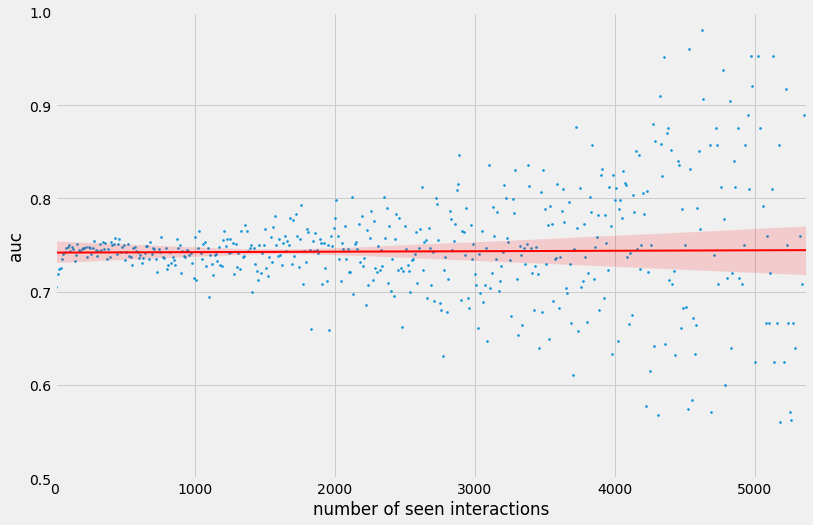

In [94]:
def roc_score_per_interaction(x):
    try:
        return roc_auc_score(x.answered_correctly.values, x.predictions.values)
    except ValueError:
        return np.nan

df["num_iteractions"] = (df.groupby("user_id").cumcount() // 10) * 10
interactions_auc = df.groupby("num_iteractions").apply(roc_score_per_interaction)
interactions_auc = interactions_auc[~interactions_auc.isna()].copy()

fig, ax = plt.subplots(figsize=(12, 8))
sns.regplot(
    y=interactions_auc.values,
    x=interactions_auc.index,
    line_kws={"color": "red", "linewidth": 2},
    scatter_kws={"s": 3},
)
ax.set_ylim(0.5, 1)
ax.set_xlim(0, interactions_auc.index.max())
ax.set_ylabel("auc")
ax.set_xlabel("number of seen interactions")
plt.show()

In [ ]:
#validation score
y_pred = pd.concat(predicted).answered_correctly
y_true = valid[valid.content_type_id == 0].answered_correctly[:len(y_pred)]

print('validation auc:',roc_auc_score(y_true, y_pred))

# Real test

In [ ]:
class Iter_Valid(object):
    def __init__(self, df, max_user=1000):
        df = df.reset_index(drop=True)
        self.df = df
        self.user_answer = df["user_answer"].astype(str).values
        self.answered_correctly = df["answered_correctly"].astype(str).values
        df["prior_group_responses"] = "[]"
        df["prior_group_answers_correct"] = "[]"
        self.sample_df = df[df["content_type_id"] == 0][["row_id"]]
        self.sample_df["answered_correctly"] = 0
        self.len = len(df)
        self.user_id = df.user_id.values
        self.task_container_id = df.task_container_id.values
        self.content_type_id = df.content_type_id.values
        self.max_user = max_user
        self.current = 0
        self.pre_user_answer_list = []
        self.pre_answered_correctly_list = []

    def __iter__(self):
        return self

    def fix_df(self, user_answer_list, answered_correctly_list, pre_start):
        df = self.df[pre_start : self.current].copy()
        sample_df = self.sample_df[pre_start : self.current].copy()
        df.loc[pre_start, "prior_group_responses"] = (
            "[" + ",".join(self.pre_user_answer_list) + "]"
        )
        df.loc[pre_start, "prior_group_answers_correct"] = (
            "[" + ",".join(self.pre_answered_correctly_list) + "]"
        )
        self.pre_user_answer_list = user_answer_list
        self.pre_answered_correctly_list = answered_correctly_list
        return df, sample_df

    def __next__(self):
        added_user = set()
        pre_start = self.current
        pre_added_user = -1
        pre_task_container_id = -1

        user_answer_list = []
        answered_correctly_list = []
        while self.current < self.len:
            crr_user_id = self.user_id[self.current]
            crr_task_container_id = self.task_container_id[self.current]
            crr_content_type_id = self.content_type_id[self.current]
            if crr_content_type_id == 1:
                # no more than one task_container_id of "questions" from any single user
                # so we only care for content_type_id == 0 to break loop
                user_answer_list.append(self.user_answer[self.current])
                answered_correctly_list.append(self.answered_correctly[self.current])
                self.current += 1
                continue
            if crr_user_id in added_user and (
                (crr_user_id != pre_added_user)
                or (crr_task_container_id != pre_task_container_id)
            ):
                # known user(not prev user or differnt task container)
                return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
            if len(added_user) == self.max_user:
                if (
                    crr_user_id == pre_added_user
                    and crr_task_container_id == pre_task_container_id
                ):
                    user_answer_list.append(self.user_answer[self.current])
                    answered_correctly_list.append(
                        self.answered_correctly[self.current]
                    )
                    self.current += 1
                    continue
                else:
                    return self.fix_df(
                        user_answer_list, answered_correctly_list, pre_start
                    )
            added_user.add(crr_user_id)
            pre_added_user = crr_user_id
            pre_task_container_id = crr_task_container_id
            user_answer_list.append(self.user_answer[self.current])
            answered_correctly_list.append(self.answered_correctly[self.current])
            self.current += 1
        if pre_start < self.current:
            return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
        else:
            raise StopIteration()

In [ ]:
%%time
inference_dataset = InferenceRIIDDataset(hdf5_file="feats_train.h5",)
iter_test = Iter_Valid(valid,max_user=1000)
predicted = []
def set_predict(df):
    predicted.append(df)

In [537]:
pbar = tqdm(total=len(valid))
previous_test_df = None
for (current_test, current_prediction_df) in iter_test:
    if previous_test_df is not None:
        previous_test_df["answered_correctly"] = eval(
            current_test["prior_group_answers_correct"].iloc[0]
        )
        previous_test_df[previous_test_df.content_type_id == 0].groupby(
            "user_id"
        ).answered_correctly.apply(inference_dataset.update_answered_correctly)

    # your feature extraction and model training code here
    previous_test_df = current_test.copy()

    # add current to cache
    current_test = current_test[current_test.content_type_id == 0]
    current_test = add_part_to_questions(current_test)
    current_test[["row_id", "user_id", "content_id", "part", "timestamp"]].groupby(
        "user_id"
    ).apply(lambda user_rows: inference_dataset.update_user_rows(user_rows))

    # your prediction code here
    current_test = predict_for_df(current_test)
    set_predict(current_test.loc[:, ["row_id", "answered_correctly"]])
    pbar.update(len(current_test))

In [538]:
#validation score
y_pred = pd.concat(predicted).answered_correctly
y_true = valid[valid.content_type_id == 0].answered_correctly[:len(y_pred)]

print('validation auc:',roc_auc_score(y_true, y_pred))

validation auc: 0.7301190955694308
